<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [479]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline



### About dataset



This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [334]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-04-29 04:10:03--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-04-29 04:10:04 (187 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [335]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [336]:
df.shape

(346, 10)

### Convert to date time object


In [337]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [338]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [425]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



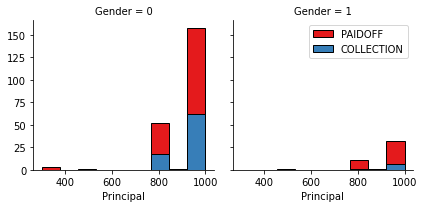

In [346]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

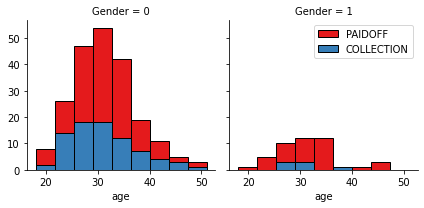

In [347]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


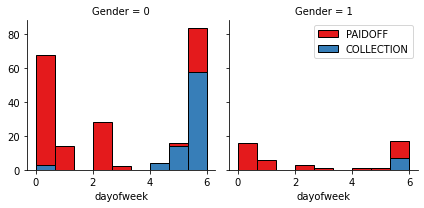

In [348]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [349]:

df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [350]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [439]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

## One Hot Encoding

#### How about education?


In [352]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [353]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [470]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [474]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [467]:

y = df['loan_status'].values
y[0:5]


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [484]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [455]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [456]:
from sklearn.neighbors import KNeighborsClassifier

In [457]:
k = 7 
KNN_neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
KNN_neigh

KNeighborsClassifier(n_neighbors=7)

In [459]:
yhat = KNN_neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [460]:
from sklearn import metrics


print("KNN Accuracy: ", metrics.accuracy_score(y_test, yhat))

KNN Accuracy:  0.7857142857142857


In [363]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

# Decision Tree


In [394]:
from sklearn.tree import DecisionTreeClassifier

In [503]:
Decision_Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Decision_Tree.fit(X_train, y_train)
Decision_Tree



DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [397]:
yhat = Decision_Tree.predict(X_test)
yhat

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Support Vector Machine


In [401]:
from sklearn import svm
SVM= svm.SVC()
SVM.fit(X_train,y_train)


SVC()

In [403]:
yhat = SVM.predict(X_test)
yhat

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Logistic Regression


In [404]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01).fit(X_train,y_train)
LR

LogisticRegression(C=0.01)

In [405]:
yhat = LR.predict(X_test)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [452]:
LR_yhat_Prob = LR.predict_proba(X)
LR_yhat_Prob

array([[0.17293253, 0.82706747],
       [0.15575919, 0.84424081],
       [0.17604004, 0.82395996],
       [0.28883375, 0.71116625],
       [0.3360649 , 0.6639351 ],
       [0.31792111, 0.68207889],
       [0.33869843, 0.66130157],
       [0.30459989, 0.69540011],
       [0.25853342, 0.74146658],
       [0.29532377, 0.70467623],
       [0.34399545, 0.65600455],
       [0.24926176, 0.75073824],
       [0.31044837, 0.68955163],
       [0.30459989, 0.69540011],
       [0.32066455, 0.67933545],
       [0.31276928, 0.68723072],
       [0.34153138, 0.65846862],
       [0.33297474, 0.66702526],
       [0.34399545, 0.65600455],
       [0.36031081, 0.63968919],
       [0.31512514, 0.68487486],
       [0.34952302, 0.65047698],
       [0.2781939 , 0.7218061 ],
       [0.3004166 , 0.6995834 ],
       [0.33082841, 0.66917159],
       [0.3256335 , 0.6743665 ],
       [0.29980921, 0.70019079],
       [0.31537209, 0.68462791],
       [0.34134199, 0.65865801],
       [0.31537209, 0.68462791],
       [0.

# Model Evaluation using Test set


In [433]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [489]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-29 06:04:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-29 06:04:05 (93.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [490]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### KN-N

In [491]:
from sklearn import preprocessing


In [497]:
KNN_yhat = KNN_neigh.predict(X)

print("KNN jaccard_score: %.2f" % jaccard_score(y, KNN_yhat, pos_label='PAIDOFF'))
print("KNN F1_score: %.2f" % f1_score(y, KNN_yhat, average='weighted'))

KNN jaccard_score: 0.78
KNN F1_score: 0.80


### DT

In [498]:
DT_yhat = Decision_Tree.predict(X)

print("DT jaccard_score: %.2f" % jaccard_score(y, DT_yhat, pos_label='PAIDOFF'))
print("DT F1_score: %.2f" % f1_score(y, DT_yhat, average='weighted'))

DT jaccard_score: 0.67
DT F1_score: 0.73


### SVM 

In [499]:
SVM_yhat = SVM.predict(X)

print("SVM jaccard_score: %.2f" % jaccard_score(y, SVM_yhat, pos_label='PAIDOFF'))
print("SVM F1_score: %.2f" % f1_score(y, SVM_yhat, average='weighted'))

SVM jaccard_score: 0.75
SVM F1_score: 0.76


### LR

In [500]:
LR_yhat = LR.predict(X)

print("LR jaccard_score: %.2f" % jaccard_score(y, LR_yhat, pos_label='PAIDOFF'))
print("LR F1_score: %.2f" % f1_score(y, LR_yhat, average='weighted'))
print("LR log_loss: %.2f" % log_loss(y, LR_yhat_Prob))

LR jaccard_score: 0.75
LR F1_score: 0.64
LR log_loss: 0.50


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.78       | 0.80        | NA      |
| Decision Tree      | 0.67    |  0.73    | NA      |
| SVM                | 0.75       | 0.76        | NA      |
| LogisticRegression | 0.75       | 0.64        | 0.50       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
